In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import kendalltau
import xgboost as xgb

print("Step 1: 读取数据...")
df = pd.read_csv("C:/Tengfei/data/results/topic_孙颖莎_metrics/test/advanced_method2_30.0pct/normal_users_after_removal.csv")
df = df[df["avg_popularity_of_all"] <= 1500]

# 10个特征列：6个网络特征 + 4个全局特征
feature_cols = [
    "average_nearest_neighbor_degree",
    "betweenness_centrality",
    "clustering_coefficient",
    "modularity",
    "density",
    "spectral_radius",
    "edge_count",
    "global_in_degree",
    "global_out_degree",
    "node_count"
]
X = df[feature_cols].astype(float).values
y = df["avg_popularity_of_all"].astype(float).values

print("Step 2: 划分训练集与测试集 (8:2)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Step 3: 定义并训练 XGBoost 模型...")
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)
print("模型训练完成！")

print("Step 4: 计算训练集 MSE...")
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
tau, p_value = kendalltau(y_train, y_train_pred)
print(f"训练集 MSE: {train_mse:.6f}, 训练集 R²: {train_r2:.6f}")
print(f"训练集 Kendall tau: {tau:.6f}, p-value: {p_value:.6f}")

print("Step 5: 计算测试集 MSE、Kendall tau...")
y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)
tau, p_value = kendalltau(y_test, y_pred)
print(f"测试集 MSE: {test_mse:.6f}, 测试集 R²: {test_r2:.6f}")
print(f"测试集 Kendall tau: {tau:.6f}, p-value: {p_value:.6f}")


print("全部运行完成！")


Step 1: 读取数据...
Step 2: 划分训练集与测试集 (8:2)...
Step 3: 定义并训练 XGBoost 模型...
模型训练完成！
Step 4: 计算训练集 MSE...
训练集 MSE: 235.222806, 训练集 R²: 0.870988
训练集 Kendall tau: 0.319379, p-value: 0.000000
Step 5: 计算测试集 MSE、Kendall tau...
测试集 MSE: 2026.924780, 测试集 R²: -0.075676
测试集 Kendall tau: 0.289078, p-value: 0.000000
全部运行完成！


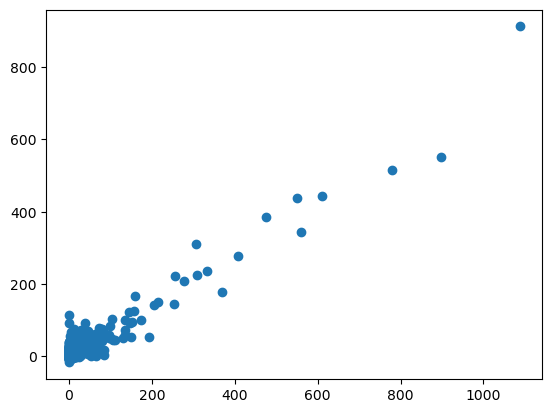

In [134]:
import matplotlib.pyplot as plt

plt.scatter(y_train,y_train_pred)
plt.show()

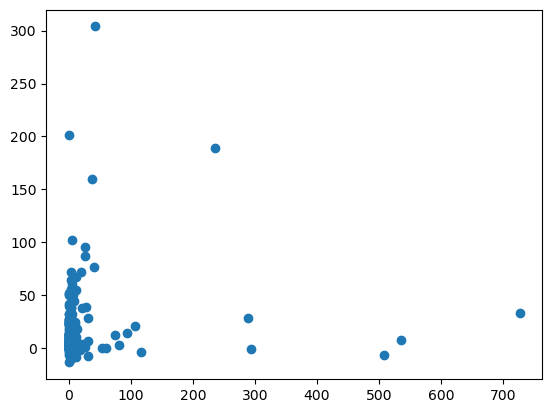

In [135]:
import matplotlib.pyplot as plt

plt.scatter(y_test,y_pred)
plt.show()

随机种子已固定为 42
Epoch 1/300 | Train MSE: 0.706877 | Val MSE: 0.496163
Epoch 50/300 | Train MSE: 0.328523 | Val MSE: 0.461505
Epoch 100/300 | Train MSE: 0.279813 | Val MSE: 0.433653
Epoch 150/300 | Train MSE: 0.251837 | Val MSE: 0.451875
Epoch 200/300 | Train MSE: 0.232448 | Val MSE: 0.483152
Epoch 250/300 | Train MSE: 0.219835 | Val MSE: 0.489832
Epoch 300/300 | Train MSE: 0.210471 | Val MSE: 0.501915
Test MSE (best model): 0.382786


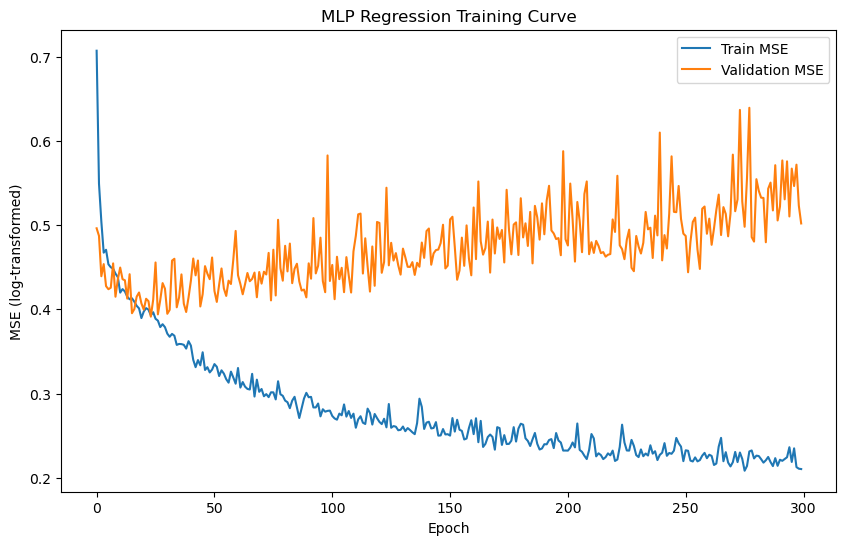

In [131]:
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)       # 如果使用 GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"随机种子已固定为 {seed}")

seed_everything(42)

# =======================
# 1. 读取数据并去掉目标为0的行
# =======================
df = pd.read_csv("C:/Tengfei/data/results/topic_孙颖莎_metrics/test/advanced_method2_30.0pct/normal_users_after_removal.csv")
# df = df[df["avg_popularity_of_all"] != 0]
df = df[df["avg_popularity_of_all"] <= 1500]

# 增为10个特征列：6个网络特征 + 4个全局特征
feature_cols = [
    "average_nearest_neighbor_degree",
    "betweenness_centrality",
    "clustering_coefficient",
    "modularity",
    "density",
    "spectral_radius",
    "edge_count",
    "global_in_degree",
    "global_out_degree",
    "node_count"
]

X = df[feature_cols].values.astype(np.float32)

# 是否需要？暂时先保留
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
# 是否需要？

y = df["avg_popularity_of_all"].values.astype(np.float32).reshape(-1, 1)

# =======================
# 对 label 做 log(y+2) 变换
# =======================
y = np.log(y + 2)

# 标准化特征
scaler = StandardScaler()
X = scaler.fit_transform(X)

# =======================
# 2. 划分训练/验证/测试集 (7:2:1)
# =======================
dataset = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# =======================
# 3. 定义 MLP 模型
# =======================
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPRegressor(input_dim=X.shape[1]).to(device)

# =======================
# 4. 损失函数和优化器
# =======================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# =======================
# 5. 训练并记录每轮 MSE，同时保存验证集最优模型
# =======================
num_epochs = 300
train_mse_history = []
val_mse_history = []
best_val_mse = float("inf")
best_model_state = None

for epoch in range(num_epochs):
    # 训练
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_mse = np.mean(train_losses)
    train_mse_history.append(train_mse)

    # 验证
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_losses.append(loss.item())
    val_mse = np.mean(val_losses)
    val_mse_history.append(val_mse)

    # 保存验证集最优模型
    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_model_state = model.state_dict()

    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} | Train MSE: {train_mse:.6f} | Val MSE: {val_mse:.6f}")

# =======================
# 6. 测试集 MSE（使用验证集最优模型）
# =======================
model.load_state_dict(best_model_state)
model.eval()
test_losses = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        test_losses.append(loss.item())
test_mse = np.mean(test_losses)
print(f"Test MSE (best model): {test_mse:.6f}")

# =======================
# 7. 绘制训练曲线
# =======================
plt.figure(figsize=(10,6))
plt.plot(train_mse_history, label="Train MSE")
plt.plot(val_mse_history, label="Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE (log-transformed)")
plt.title("MLP Regression Training Curve")
plt.legend()
plt.show()


Train Kendall tau: 0.542131, p-value: 0.000000


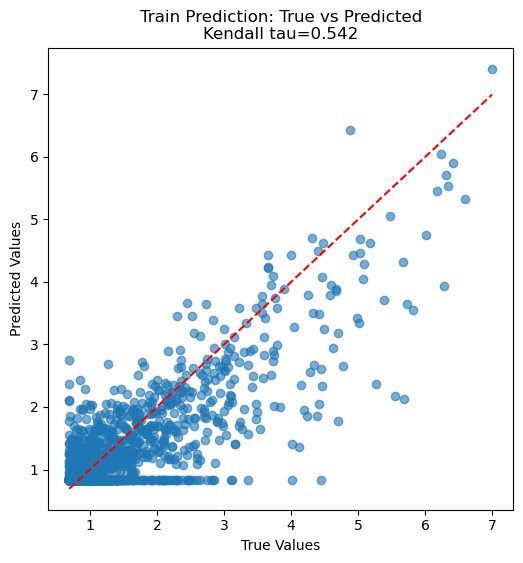

Test Kendall tau: 0.521172, p-value: 0.000000


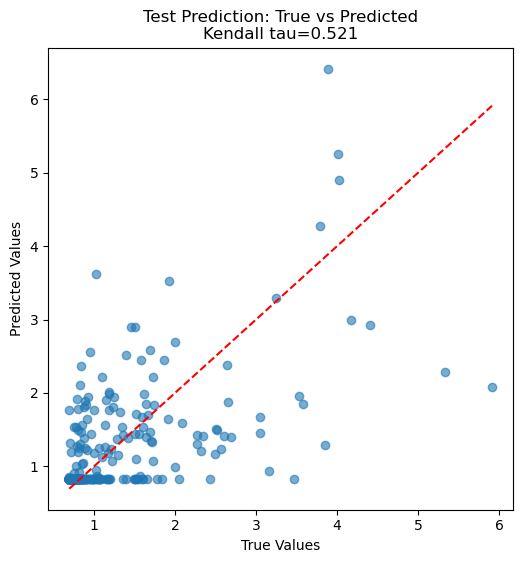

In [132]:
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np

def plot_predictions(model, data_loader, dataset_name="Data"):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for xb, yb in data_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            y_true.append(yb.cpu().numpy())
            y_pred.append(preds.cpu().numpy())
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    # 计算 Kendall tau
    tau, p_value = kendalltau(y_true, y_pred)
    print(f"{dataset_name} Kendall tau: {tau:.6f}, p-value: {p_value:.6f}")

    # 绘制散点图
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # y=x参考线
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{dataset_name} Prediction: True vs Predicted\nKendall tau={tau:.3f}")
    plt.show()

# 绘制训练集预测效果
plot_predictions(model, train_loader, "Train")

# 绘制测试集预测效果
plot_predictions(model, test_loader, "Test")
